In [1]:
pip install datasets

In [2]:
# Load data from Hugging Face
from datasets import load_dataset
dataset = load_dataset("maartengr/arxiv_nlp")["train"]

# Extract metadata
abstracts = dataset["Abstracts"]
titles = dataset["Titles"]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# Text Clustering

## 1. Embedding

In [3]:
from sentence_transformers import SentenceTransformer

# Create an embedding for each abstract
embedding_model = SentenceTransformer("thenlper/gte-small")
embeddings = embedding_model.encode(abstracts, show_progress_bar=True)

Batches:   0%|          | 0/1405 [00:00<?, ?it/s]

In [4]:
# Check the dimensions of the resulting embeddings
embeddings.shape

(44949, 384)

## 2. Dimensionality Reduction

In [5]:
from umap import UMAP

# We reduce the input embeddings from 384 dimensions to 5 dimensions
umap_model = UMAP(n_components=5, min_dist=0.0, metric='cosine', random_state=42)      # UMAP Captures non-linear relationships
reduced_embeddings = umap_model.fit_transform(embeddings)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


## 3. Clustering

In [6]:
from hdbscan import HDBSCAN

# We fit the model and extract the clusters
hdbscan_model = HDBSCAN(min_cluster_size=50, metric="euclidean", cluster_selection_method="eom").fit(reduced_embeddings)
clusters = hdbscan_model.labels_

# How many clusters did we generate?
len(set(clusters))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


161

In [7]:
import numpy as np

# Print first three documents in cluster 0
cluster = 0
for index in np.where(clusters==cluster)[0][:3]:
  print(abstracts[index][:300] + "... \n")

  This works aims to design a statistical machine translation from English text
to American Sign Language (ASL). The system is based on Moses tool with some
modifications and the results are synthesized through a 3D avatar for
interpretation. First, we translate the input text to gloss, a written fo... 

  Researches on signed languages still strongly dissociate lin- guistic issues
related on phonological and phonetic aspects, and gesture studies for
recognition and synthesis purposes. This paper focuses on the imbrication of
motion and meaning for the analysis, synthesis and evaluation of sign lang... 

  Modern computational linguistic software cannot produce important aspects of
sign language translation. Using some researches we deduce that the majority of
automatic sign language translation systems ignore many aspects when they
generate animation; therefore the interpretation lost the truth inf... 



## 4. Plotting Clusters

In [8]:
import pandas as pd

# Reduce 384-dimensional embeddings to two dimensions for easier visualization
reduced_embeddings = UMAP(
n_components=2, min_dist=0.0, metric="cosine", random_state=42
).fit_transform(embeddings)

# Create dataframe
df = pd.DataFrame(reduced_embeddings, columns=["x", "y"])
df["title"] = titles
df["cluster"] = [str(c) for c in clusters]

# Select outliers and non-outliers (clusters)
clusters_df = df.loc[df['cluster'] != "-1", :]
outliers_df = df.loc[df['cluster'] == "-1", :]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(np.float64(-8.48597011566162),
 np.float64(11.673624610900879),
 np.float64(-1.1901315301656723),
 np.float64(16.66170398890972))

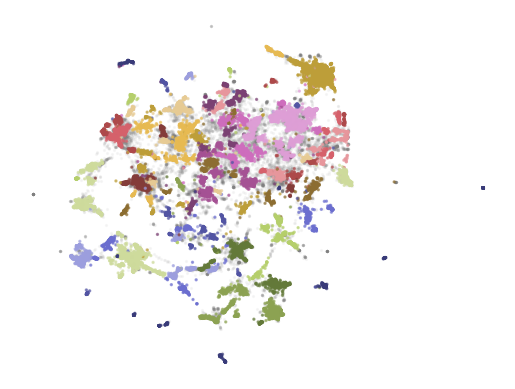

In [9]:
import matplotlib.pyplot as plt

# Plot outliers and non-outliers separately
plt.scatter(outliers_df['x'], outliers_df['y'], alpha=0.05, s=2, c="grey")
plt.scatter(
clusters_df['x'], clusters_df['y'], c=clusters_df.cluster.astype(int),
alpha=0.6, s=2, cmap="tab20b")
plt.axis("off")

# Topic Modeling

BERToic is a workframe for topic modeling

## 1. BERTopic pipeline

In [10]:
pip install bertopic

In [11]:
from bertopic import BERTopic

# Train our model with our previously defined models
topic_model = BERTopic(
embedding_model=embedding_model,
umap_model=umap_model,
hdbscan_model=hdbscan_model,
verbose=True).fit(abstracts, embeddings)

2025-04-15 18:21:23,846 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-15 18:22:36,355 - BERTopic - Dimensionality - Completed ✓
2025-04-15 18:22:36,361 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-15 18:22:38,613 - BERTopic - Cluster - Completed ✓
2025-04-15 18:22:38,637 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-15 18:22:42,537 - BERTopic - Representation - Completed ✓


## 2. Exploring

In [12]:
# Exploring topics (Clusters)
topic_model.get_topic_info()

Topic  Count                                           Name  \
0       -1  14633                               -1_the_of_and_to   
1        0   2170                   0_speech_asr_recognition_end   
2        1   1513          1_medical_clinical_biomedical_patient   
3        2   1064                 2_translation_nmt_machine_bleu   
4        3    878  3_summarization_summaries_summary_abstractive   
..     ...    ...                                            ...   
156    155     52            155_gans_gan_adversarial_generation   
157    156     52  156_counterfactual_counterfactuals_cad_causal   
158    157     51    157_reviews_opinion_summaries_summarization   
159    158     51         158_sentence_embeddings_similarity_sts   
160    159     51   159_diffusion_generation_autoregressive_text   

                                        Representation  \
0    [the, of, and, to, in, we, that, for, language...   
1    [speech, asr, recognition, end, acoustic, spea...   
2    [medical, clinical, biomedical, patient, healt...   
3    [translation, nmt, machine, bleu, neural, engl...   
4    [summarization, summaries, summary, abstractiv...   
..                                                 ...   
156  [gans, gan, adversarial, generation, generativ...   
157  [counterfactual, counterfactuals, cad, causal,...   
158  [reviews, opinion, summaries, summarization, r...   
159  [sentence, embeddings, similarity, sts, embedd...   
160  [diffusion, generation, autoregressive, text, ...   

                                   Representative_Docs  
0    [  Large-scale generative language models such...  
1    [  We introduce the Universal Speech Model (US...  
2    [  Medical text learning has recently emerged ...  
3    [  Neural Machine Translation (NMT) has obtain...  
4    [  Abstractive summarization systems generally...  
..                                                 ...  
156  [  Text generation is of particular interest i...  
157  [  For text classification tasks, finetuned la...  
158  [  When faced with a large number of product r...  
159  [  Contextualized representations from a pre-t...  
160  [  Diffusion models have achieved great succes...  

[161 rows x 5 columns]

In [13]:
# Exploring keywords that represent a specific topic
topic_model.get_topic(0)

[('speech', np.float64(0.02828681634228534)),
 ('asr', np.float64(0.019017583376772486)),
 ('recognition', np.float64(0.01351852460855774)),
 ('end', np.float64(0.010021998997227385)),
 ('acoustic', np.float64(0.009620070457067404)),
 ('speaker', np.float64(0.006916167175150833)),
 ('audio', np.float64(0.006808378135447608)),
 ('wer', np.float64(0.006463622262564082)),
 ('error', np.float64(0.00642401895376032)),
 ('automatic', np.float64(0.006194975046856624))]

In [14]:
# Searching for a specific topics that has a relatively high similarity
topic_model.find_topics("topic modeling")

([27, -1, 1, 35, 39],
 [np.float32(0.95476),
  np.float32(0.9120362),
  np.float32(0.90857774),
  np.float32(0.90765),
  np.float32(0.9046601)])

In [15]:
topic_model.get_topic(22)

[('commonsense', np.float64(0.06978426123901262)),
 ('knowledge', np.float64(0.02395338874071697)),
 ('reasoning', np.float64(0.019319224942596545)),
 ('graph', np.float64(0.006645245215433505)),
 ('models', np.float64(0.006509083701383503)),
 ('graphs', np.float64(0.006403898051974601)),
 ('that', np.float64(0.006305674063397555)),
 ('answering', np.float64(0.00605881534104021)),
 ('question', np.float64(0.006046896787885746)),
 ('concepts', np.float64(0.005986007185036414))]

In [17]:
# Adding a sentence to see where it may belong
topic_model.topics_[titles.index("BERTopic: Neural topic modeling with a classbased TF-IDF procedure")]

ValueError: 'BERTopic: Neural topic modeling with a classbased TF-IDF procedure' is not in list

## 3. Visualization

In [18]:
# Visualize topics and documents
fig = topic_model.visualize_documents(
titles,
reduced_embeddings=reduced_embeddings,
width=1200,
hide_annotations=True)

# Update fonts of legend for easier visualization
fig.update_layout(font=dict(size=16))

In [19]:
# Visualize barchart with ranked keywords
topic_model.visualize_barchart()

In [20]:
# Visualize relationships between topics
topic_model.visualize_heatmap(n_clusters=30)

In [21]:
# Visualize the potential hierarchical structure of topics
topic_model.visualize_hierarchy()

In [22]:
# Save original representations
from copy import deepcopy
original_topics = deepcopy(topic_model.topic_representations_)

In [24]:
def topic_differences(model, original_topics, nr_topics=5):
  """Show the differences in topic representations between two models """
  df = pd.DataFrame(columns=["Topic", "Original", "Updated"])
  for topic in range(nr_topics):
    # Extract top 5 words per topic per model
    og_words = " | ".join(list(zip(*original_topics[topic]))[0][:5])
    new_words = " | ".join(list(zip(*model.get_topic(topic)))[0][:5])
    df.loc[len(df)] = [topic, og_words, new_words]
  return df

## Improvements

KeyBERTInspired tends to remove nearly all stop words since it focuses on the semantic relationships between words and documents

In [25]:
from bertopic.representation import KeyBERTInspired

# Update our topic representations using KeyBERTInspired
representation_model = KeyBERTInspired()
topic_model.update_topics(abstracts, representation_model=representation_model)
# Show topic differences
topic_differences(topic_model, original_topics)

Topic                                           Original  \
0      0        speech | asr | recognition | end | acoustic   
1      1  medical | clinical | biomedical | patient | he...   
2      2        translation | nmt | machine | bleu | neural   
3      3  summarization | summaries | summary | abstract...   
4      4      hate | offensive | speech | detection | toxic   

                                             Updated  
0  phonetic | speech | language | encoder | trans...  
1            nlp | ehr | clinical | annotated | text  
2  translation | translate | translated | transla...  
3  summarization | summarizers | summaries | summ...  
4  hate | hateful | offensive | cyberbullying | l...

MMR filters out redundant keywords

In [26]:
from bertopic.representation import MaximalMarginalRelevance

# Update our topic representations to MaximalMarginalRelevance
representation_model = MaximalMarginalRelevance(diversity=0.2)
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

Topic                                           Original  \
0      0        speech | asr | recognition | end | acoustic   
1      1  medical | clinical | biomedical | patient | he...   
2      2        translation | nmt | machine | bleu | neural   
3      3  summarization | summaries | summary | abstract...   
4      4      hate | offensive | speech | detection | toxic   

                                             Updated  
0              speech | asr | audio | wer | training  
1  medical | clinical | biomedical | patient | he...  
2       translation | nmt | bleu | neural | parallel  
3  summarization | summaries | abstractive | fact...  
4       hate | offensive | toxic | abusive | hateful

Use text generative LLMs and prompt engineering to create a single label for each topic from keywords and documents related to each topic.

In [27]:
from transformers import pipeline
from bertopic.representation import TextGeneration

prompt = """I have a topic that contains the following documents:
[DOCUMENTS]
The topic is described by the following keywords: '[KEYWORDS]'.
Based on the documents and keywords, what is this topic about?"""

# Update our topic representations using Flan-T5
generator = pipeline("text2text-generation", model="google/flan-t5-small")
representation_model = TextGeneration(generator, prompt=prompt, doc_length=50, tokenizer="whitespace")
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Device set to use cuda:0
100%|██████████| 161/161 [00:14<00:00, 10.82it/s]


Topic                                           Original  \
0      0        speech | asr | recognition | end | acoustic   
1      1  medical | clinical | biomedical | patient | he...   
2      2        translation | nmt | machine | bleu | neural   
3      3  summarization | summaries | summary | abstract...   
4      4      hate | offensive | speech | detection | toxic   

                           Updated  
0   Speech recognition |  |  |  |   
1         Science/Tech |  |  |  |   
2  Machine translation |  |  |  |   
3        Summarization |  |  |  |   
4          Hate Speech |  |  |  |

In [ ]:
import openai
from bertopic.representation import OpenAI

prompt = """
I have a topic that contains the following documents:
[DOCUMENTS]
The topic is described by the following keywords: [KEYWORDS]
Based on the information above, extract a short topic label in the following
format:
topic: <short topic label>
"""

# Update our topic representations using GPT-3.5
client = openai.OpenAI(api_key="YOUR_KEY_HERE")
representation_model = OpenAI(
client, model="gpt-3.5-turbo", exponential_backoff=True, chat=True,
prompt=prompt
)
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

In [ ]:
fig = topic_model.visualize_document_datamap(
titles,
topics=list(range(20)),
reduced_embeddings=reduced_embeddings,
width=1200,
label_font_size=11,
label_wrap_width=20,
use_medoids=True,
)